## Binary Classification Modeling with Logistic Regression, Random Forests, and Naïve Bayes

*Imports*

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.svm import SVC

*Dataset*

In [2]:
corpus = pd.read_csv("../datasets/rivalry_df.csv")

corpus.head(3)

,Comments,Team
0,Not scared of Bauer. Let's fucking rattle him.,Giants
1,Obligatory going to the game today. Heard ther...,Giants
2,https://www.mlb.com/all-star/ballot \n\nHave y...,Giants


*Check for nulls*

In [3]:
corpus.isnull().sum()

Comments    0
Team        0
dtype: int64

*Check Datatypes*

In [4]:
corpus.dtypes

Comments    object
Team        object
dtype: object

### Baseline Score

*The initial baseline score is 62.8%, which lends to a mildly uneven class distribution.

In [5]:
corpus['Team'].value_counts(normalize = True)

Giants     0.627532
Dodgers    0.372468
Name: Team, dtype: float64

Vectorize and put into a dataframe

### EDA

**Top 10 words**

In [68]:
#removed bot spam and added them as stop words
add_stop_words = ['just', 'https','github', 'troxellophilus','like','com','kcadqxnqa_4', 'youtube', 'clerk']
stop_words = (CountVectorizer(stop_words = 'english').get_stop_words())
stop_words = stop_words.union(add_stop_words)

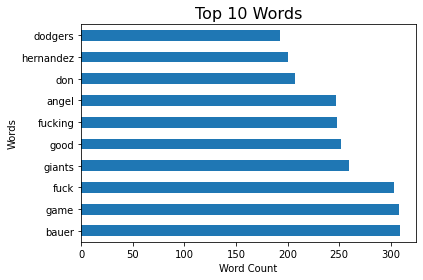

In [129]:
cv_words= CountVectorizer(ngram_range = (1,1), stop_words = stop_words)

words_df = pd.DataFrame(cv_words.fit_transform(corpus['Comments']).todense(), 
                          columns=cv_words.get_feature_names())

# plot top occuring words
words_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');

plt.title('Top 10 Words',fontsize = 16)
plt.xlabel('Word Count')
plt.ylabel('Words')
plt.savefig("../Images/top_10_words", bbox_inches="tight")

**Top 10 Bigrams**

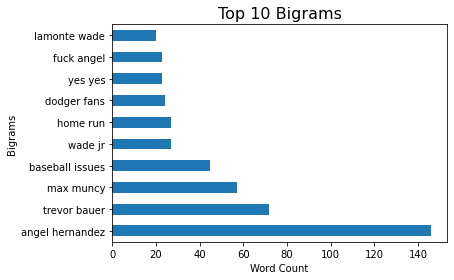

In [128]:
cv_bigrams = CountVectorizer(ngram_range = (2,2), stop_words = stop_words)

bigrams_df = pd.DataFrame(cv_bigrams.fit_transform(corpus['Comments']).todense(), 
                          columns=cv_bigrams.get_feature_names())

# plot top occuring words
bigrams_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');

plt.title('Top 10 Bigrams',fontsize = 16)
plt.xlabel('Word Count')
plt.ylabel('Bigrams')
plt.savefig("../Images/top_10_bigrams", bbox_inches="tight")

**Top 10 Trigrams**


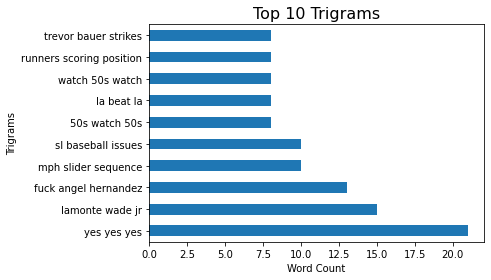

In [130]:
cv_trigrams = CountVectorizer(ngram_range = (3,3), stop_words = stop_words)

trigrams_df = pd.DataFrame(cv_trigrams.fit_transform(corpus['Comments']).todense(), 
                          columns=cv_trigrams.get_feature_names())

# plot top occuring words
trigrams_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');

plt.title('Top 10 Trigrams',fontsize = 16)
plt.xlabel('Word Count')
plt.ylabel('Trigrams')
plt.savefig("../Images/top_10_trigrams", bbox_inches="tight")

### Model Pipeline 1: Random Forest

In [33]:
pipe_1 = Pipeline([
    ('cv', CountVectorizer(stop_words = stop_words, ngram_range = (1,3))),
    ('rf', RandomForestClassifier())
])

params_1 = {
    'rf__n_estimators' : [75, 100, 125],
    'rf__max_features' : [None, 'auto'],
    'rf__max_depth'    : [2,3,4,5],
    'rf__min_samples_split' : [3,4,5],
    
}

gs_1 = GridSearchCV(pipe_1, param_grid = params_1, cv = 5, verbose = 1)
gs_1.fit(corpus['Comments'], corpus['Team'])

#Save the Gridsearch models 

# with open('../datasets/random_forest_pipe_1.pkl', 'wb') as file:
#     pickle.dump(gs_1, file)
with open('../datasets/random_forest_pipe_1.pkl', 'rb') as file:
    gs_1_random_forest = pickle.load(file)

    
search_results_1 = gs_1_random_forest.cv_results_
top_estimator_1 = gs_1_random_forest.best_estimator_
top_score_1 = gs_1_random_forest.best_score_
top_parameters_1 = gs_1_random_forest.best_params_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [35]:
gs_df_1 = pd.DataFrame(search_results_1)
gs_df_1.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__max_depth,param_rf__max_features,param_rf__min_samples_split,param_rf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.820586,0.068124,0.034101,0.005351,2,None,3,75,"{'rf__max_depth': 2, 'rf__max_features': None,...",0.636076,0.646361,0.647943,0.638449,0.631329,0.640032,0.006269,28
1,1.019639,0.068539,0.036830,0.007764,2,None,3,100,"{'rf__max_depth': 2, 'rf__max_features': None,...",0.636076,0.646361,0.648734,0.634494,0.631329,0.639399,0.006868,31
2,1.222444,0.067512,0.035480,0.001347,2,None,3,125,"{'rf__max_depth': 2, 'rf__max_features': None,...",0.636076,0.646361,0.647943,0.634494,0.631329,0.639241,0.006657,32


In [112]:
top_score_1

0.6574367088607594

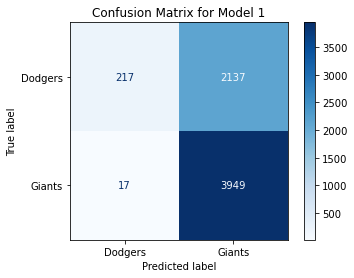

In [133]:
X = corpus['Comments']
y = corpus['Team']
plot_confusion_matrix(gs_1, X, y, cmap='Blues', values_format='d');
plt.title("Confusion Matrix for Model 1")
plt.savefig("../Images/confusion_matrix_gs_1", bbox_inches="tight")

### Model Pipeline 2: Logistic Regression

In [84]:
#Establish the model pipeline and parameter grid

pipe_2 = Pipeline([
    ('cv', CountVectorizer(stop_words = 'english', ngram_range = (1,3))),
    ('logreg', LogisticRegression(solver = 'saga'))
])
    


params_2 = {
    'logreg__penalty': ['l2','l1'],
    'logreg__max_iter':[5000]
}

#Run a grid search on using the Logistic Regression Hyperparameters

gs_2 = GridSearchCV(pipe_2, param_grid = params_2, cv = 5, verbose = 1)
gs_2.fit(corpus['Comments'], corpus['Team'])


#Save the Gridsearch models 

# with open('../datasets/logreg_pipe_2.pkl', 'wb') as file:
#     pickle.dump(gs_2, file)
with open('../datasets/logreg_pipe_2.pkl', 'rb') as file:
    gs_2_logreg = pickle.load(file)

    
search_results_2 = gs_2_logreg.cv_results_
top_estimator_2 = gs_2_logreg.best_estimator_
top_score_2 = gs_2_logreg.best_score_
top_parameters_2 = gs_2_logreg.best_params_



Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [90]:
gs_df_2 = pd.DataFrame(search_results_2)
gs_df_2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logreg__max_iter,param_logreg__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.752177,0.633027,0.029785,0.005565,5000,l2,"{'logreg__max_iter': 5000, 'logreg__penalty': ...",0.735759,0.710443,0.710443,0.670095,0.648734,0.695095,0.031302,1
1,88.696714,7.043769,0.029158,0.006250,5000,l1,"{'logreg__max_iter': 5000, 'logreg__penalty': ...",0.716772,0.708070,0.707278,0.655063,0.632911,0.684019,0.033594,2


In [109]:
top_score_2

0.6950949367088608

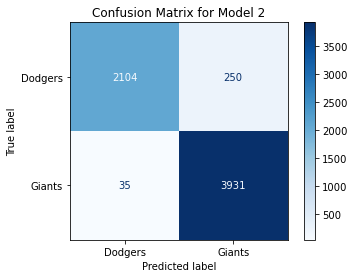

In [132]:
X = corpus['Comments']
y = corpus['Team']
plot_confusion_matrix(gs_2, X, y, cmap='Blues', values_format='d');
plt.title("Confusion Matrix for Model 2")
plt.savefig("../Images/confusion_matrix_gs_2", bbox_inches="tight")

### Model Pipeline 3: Naïve Bayes

In [124]:

pipe_3 = Pipeline([
    ('cv', CountVectorizer()),
    ('nb', MultinomialNB())
])


params_3 = {
    'cv__stop_words': [stop_words],
    'cv__ngram_range':[(1,3)]
}

gs_3 = GridSearchCV(pipe_3, param_grid = params_3, cv = 5, verbose = 1)
gs_3.fit(corpus['Comments'], corpus['Team'])


#Save the Gridsearch models 

# with open('../datasets/NB_pipe_3.pkl', 'wb') as file:
#     pickle.dump(gs_3, file)
with open('../datasets/NB_pipe_3.pkl', 'rb') as file:
    gs_3_NB = pickle.load(file)

    
search_results_3 = gs_3_NB.cv_results_
top_estimator_3 = gs_3_NB.best_estimator_
top_score_3 = gs_3_NB.best_score_
top_parameters_3 = gs_3_NB.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [125]:
gs_df_3 = pd.DataFrame(search_results_3)
gs_df_3

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cv__ngram_range,param_cv__stop_words,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.186466,0.026145,0.026309,0.00666,"(1, 3)","(sixty, together, else, since, anywhere, pleas...","{'cv__ngram_range': (1, 3), 'cv__stop_words': ...",0.727848,0.693829,0.72943,0.685918,0.656646,0.698734,0.027385,1


In [126]:
top_score_3

0.6987341772151898

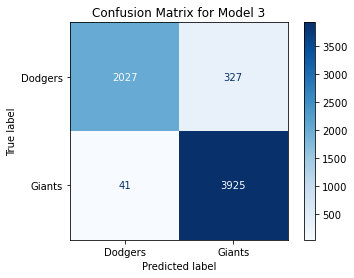

In [131]:
X = corpus['Comments']
y = corpus['Team']
plot_confusion_matrix(gs_3, X, y, cmap='Blues', values_format='d');
plt.title("Confusion Matrix for Model 3")
plt.savefig("../Images/confusion_matrix_gs_3", bbox_inches="tight")

### Model Pipeline 4: Logistic Regression with TfidfVectorizer

In [99]:
pipe_4 = Pipeline([  
    ('tf', TfidfVectorizer()),
    ('lr', LogisticRegression(solver = 'liblinear'))
])

params_4 = {

    'tf__max_features':[1000,2000,3000],
    'tf__min_df':[1,2,3],
    'tf__ngram_range':[(1,1), (1,2),(1,3)],
    'tf__stop_words': [None, stop_words],
    

    
}

gs_4 = GridSearchCV(pipe_4, param_grid = params_4, cv = 5, verbose = 1)
gs_4.fit(corpus['Comments'], corpus['Team'])

# with open('../datasets/logreg_pipe_4.pkl', 'wb') as file:
#     pickle.dump(gs_4, file)
with open('../datasets/logreg_pipe_4.pkl', 'rb') as file:
    gs_4_logreg = pickle.load(file)
    

search_results_4 = gs_4_logreg.cv_results_
top_estimator_4 = gs_4_logreg.best_estimator_
top_score_4 = gs_4_logreg.best_score_
top_parameters_4 = gs_4_logreg.best_params_


Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [100]:
gs_df_4 = pd.DataFrame(search_results_4)
gs_df_4

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logreg__max_iter,param_logreg__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.752177,0.633027,0.029785,0.005565,5000,l2,"{'logreg__max_iter': 5000, 'logreg__penalty': ...",0.735759,0.710443,0.710443,0.670095,0.648734,0.695095,0.031302,1
1,88.696714,7.043769,0.029158,0.006250,5000,l1,"{'logreg__max_iter': 5000, 'logreg__penalty': ...",0.716772,0.708070,0.707278,0.655063,0.632911,0.684019,0.033594,2


In [114]:
top_score_4

0.6950949367088608

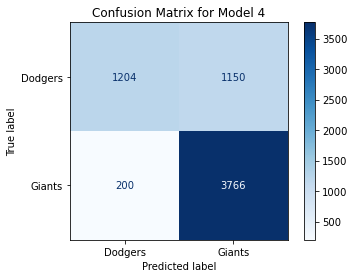

<Figure size 864x864 with 0 Axes>

In [135]:
X = corpus['Comments']
y = corpus['Team']
plot_confusion_matrix(gs_4, X, y, cmap='Blues', values_format='d');
plt.title("Confusion Matrix for Model 4")
plt.figure(figsize = (12,12))
plt.savefig("../Images/confusion_matrix_gs_4", bbox_inches="tight");